In [1]:
import sys

!{sys.executable} -m pip install -q mido tqdm pandas tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.0 MB/s eta 0:00:00


In [2]:
import mido
import numpy as np
from mido import Message, MidiFile, MidiTrack
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from music21 import *
import pandas as pd

In [3]:
mid = MidiFile(
    "/content/drive/MyDrive/FYP files/piano_sample.mid"
)
notes = []

In [ ]:
def get_notes_chords_rests(path):
    try:
        midi = converter.parse(path)
        parts = instrument.partitionByInstrument(midi)
        note_list = []
        for music_instrument in range(len(parts)):
              for element_by_offset in stream.iterator.OffsetIterator(parts[music_instrument]):
                  for entry in element_by_offset:
                      if isinstance(entry, note.Note):
                          note_list.append(str(entry.pitch))
                      elif isinstance(entry, chord.Chord):
                          note_list.append('.'.join(str(n) for n in entry.normalOrder))
                      elif isinstance(entry, note.Rest):
                          note_list.append('Rest')
        return note_list
    except Exception as e:
        print("failed on ", path)
        pass

In [ ]:
noteList = get_notes_chords_rests("/content/drive/MyDrive/FYP files/piano_sample.mid")

In [ ]:
print(noteList[:15])

['Rest', 'Rest', 'Rest', 'E-5', 'F5', 'E-3', 'Rest', 'G5', 'Rest', 'Rest', 'E-4', '3.7', 'Rest', 'Rest', 'D3']


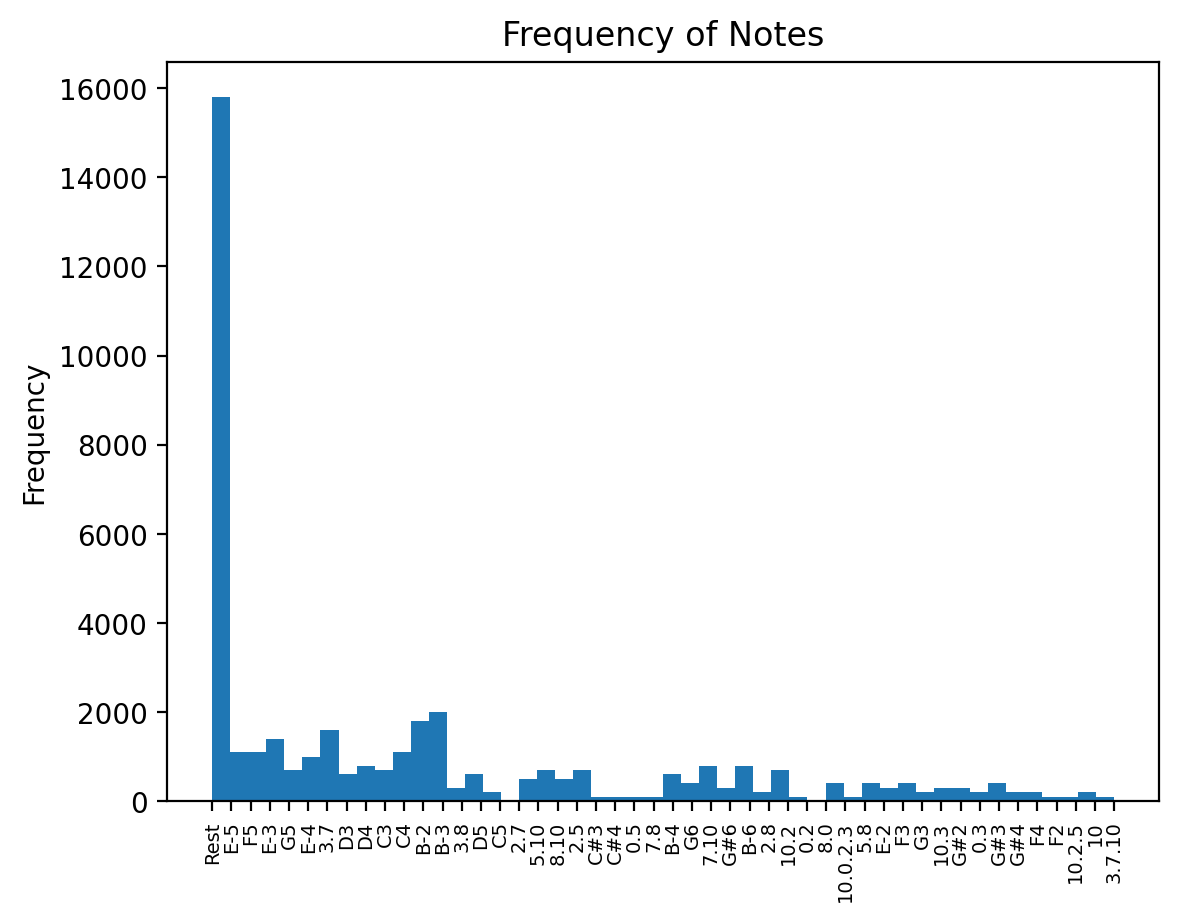

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

x = np.array(noteList)
plt.hist(x, bins=50)
plt.gca().set(title='Frequency of Notes', ylabel='Frequency');
plt.xticks(rotation = 90)
plt.xticks(fontsize=7)
plt.savefig('notes_frequency.png')

plt.show()

In [4]:
notes = []
notes_base = []
for msg in mid:
    if not msg.is_meta and msg.channel == 0 and msg.type == "note_on":
        data = msg.bytes()
        notes.append(data)
        notes_base.append(msg)

In [5]:
notes_base[:10]

[Message('note_on', channel=0, note=51, velocity=67, time=0),
 Message('note_on', channel=0, note=63, velocity=67, time=0),
 Message('note_on', channel=0, note=50, velocity=67, time=0),
 Message('note_on', channel=0, note=62, velocity=67, time=0),
 Message('note_on', channel=0, note=48, velocity=67, time=0),
 Message('note_on', channel=0, note=60, velocity=67, time=0),
 Message('note_on', channel=0, note=46, velocity=67, time=0),
 Message('note_on', channel=0, note=58, velocity=67, time=0),
 Message('note_on', channel=0, note=51, velocity=67, time=0),
 Message('note_on', channel=0, note=63, velocity=67, time=0)]

In [6]:
print(notes[:5])

[[144, 51, 67], [144, 63, 67], [144, 50, 67], [144, 62, 67], [144, 48, 67]]


In [ ]:
mid = mido.MidiFile('/content/drive/MyDrive/FYP files/piano_sample.mid', clip=True)
mid.tracks

[MidiTrack([
   MetaMessage('set_tempo', tempo=500000, time=0),
   MetaMessage('track_name', name='<Title>', time=0),
   MetaMessage('copyright', text='@<copyright>', time=0),
   MetaMessage('end_of_track', time=0)]),
 MidiTrack([
   MetaMessage('track_name', name='Piano (Left Hand)', time=0),
   Message('control_change', channel=0, control=7, value=127, time=0),
   Message('control_change', channel=0, control=10, value=64, time=0),
   Message('control_change', channel=0, control=0, value=0, time=0),
   Message('control_change', channel=0, control=32, value=0, time=0),
   Message('program_change', channel=0, program=0, time=0),
   Message('control_change', channel=0, control=93, value=0, time=0),
   MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('key_signature', key='Eb', time=0),
   Message('control_change', channel=0, control=93, value=0, time=1024),
   Message('note_on', channel=0, note=51, veloci

In [13]:
import string

In [14]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [15]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [16]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [17]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

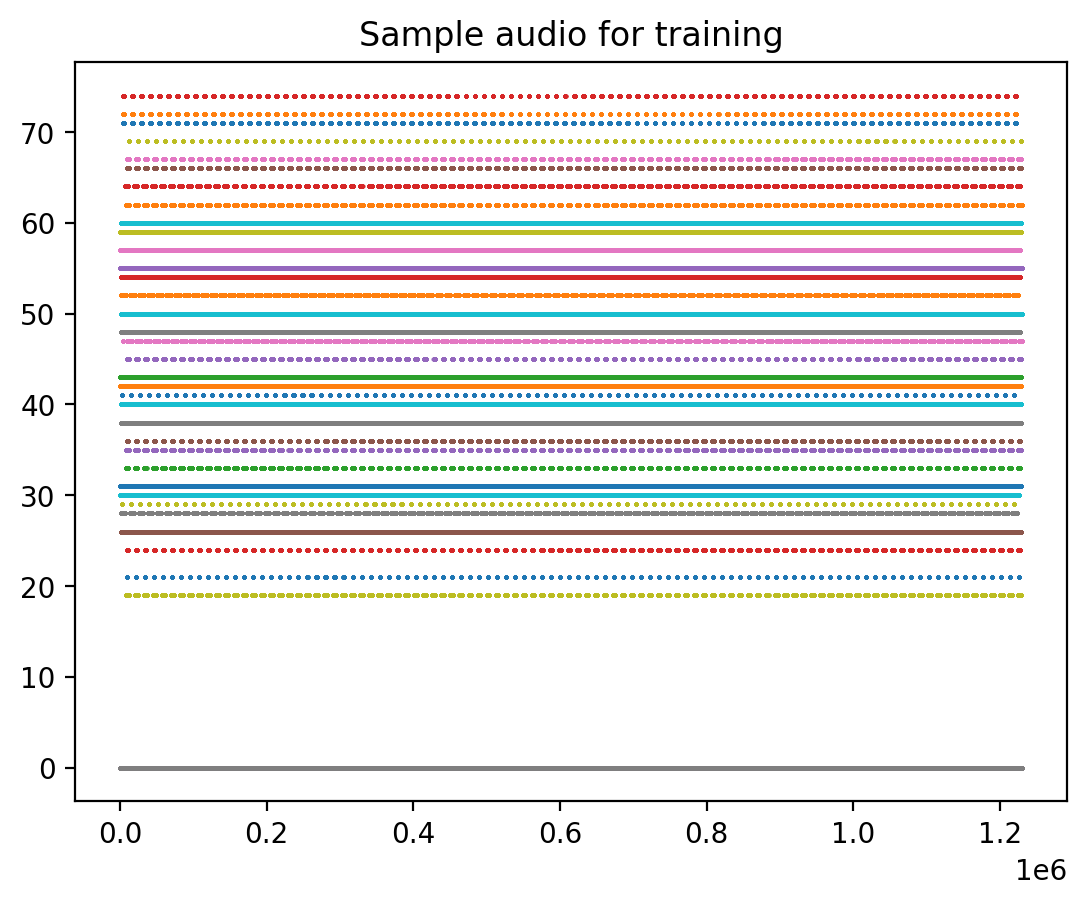

In [ ]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Sample audio for training")
plt.savefig("training_sample.png")
plt.show()

In [ ]:
mid = mido.MidiFile('/content/drive/MyDrive/FYP files/midi/cs1-1pre.mid', clip=True)
mid.tracks

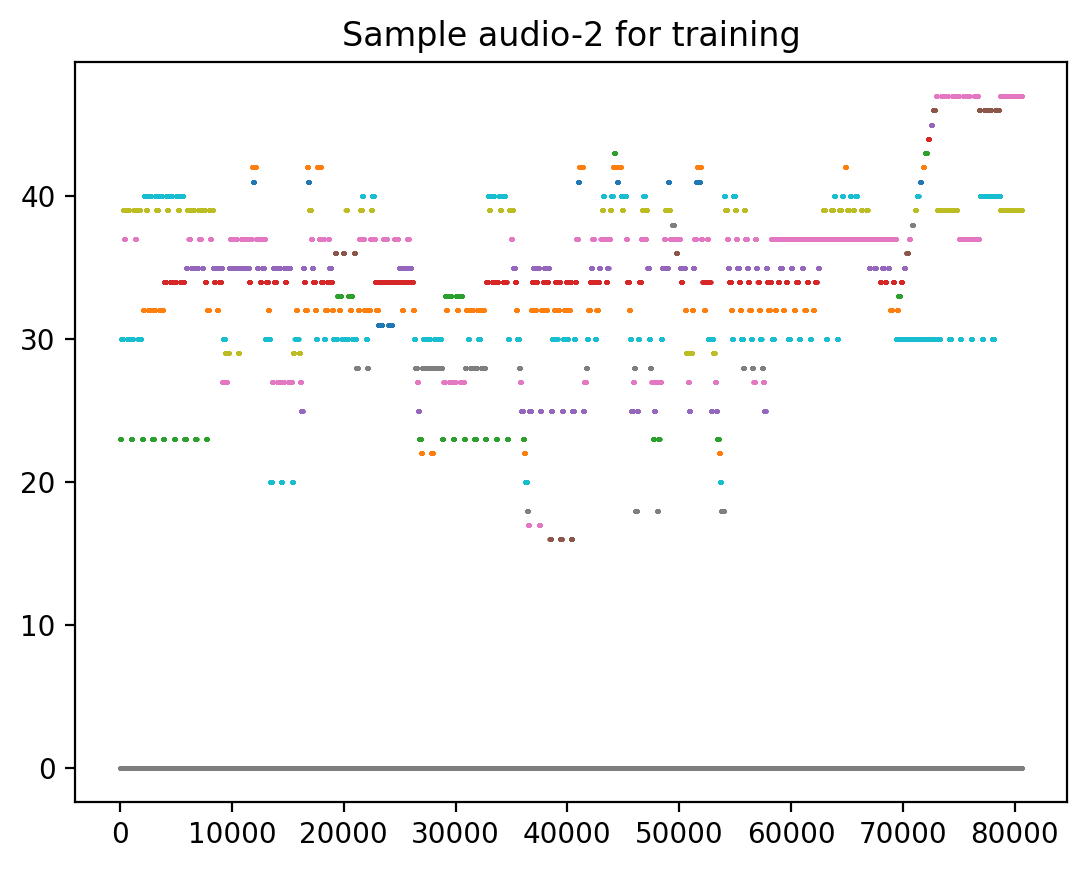

In [21]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Sample audio-2 for training")
plt.savefig("training_sample-2.png")
plt.show()

In [ ]:
mid = mido.MidiFile('/content/drive/MyDrive/FYP files/midi/arp.mid', clip=True)
mid.tracks

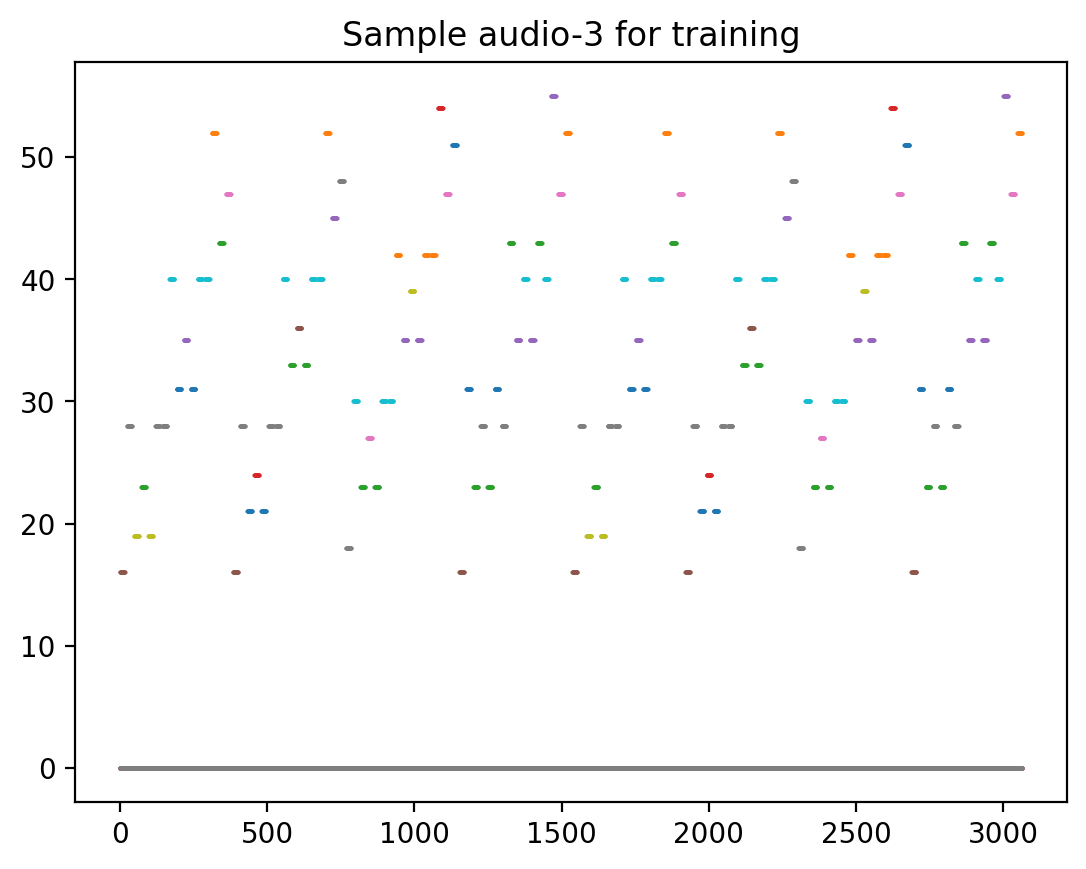

In [23]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Sample audio-3 for training")
plt.savefig("training_sample-3.png")
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(notes).reshape(-1, 1))
notes = list(scaler.transform(np.array(notes).reshape(-1, 1)))

In [6]:
notes = [list(note) for note in notes]


X = []
y = []

n_prev = 30
for i in range(len(notes) - n_prev):
    X.append(notes[i : i + n_prev])
    y.append(notes[i + n_prev])
X_test = X[-300:]
X = X[:-300]
y = y[:-300]

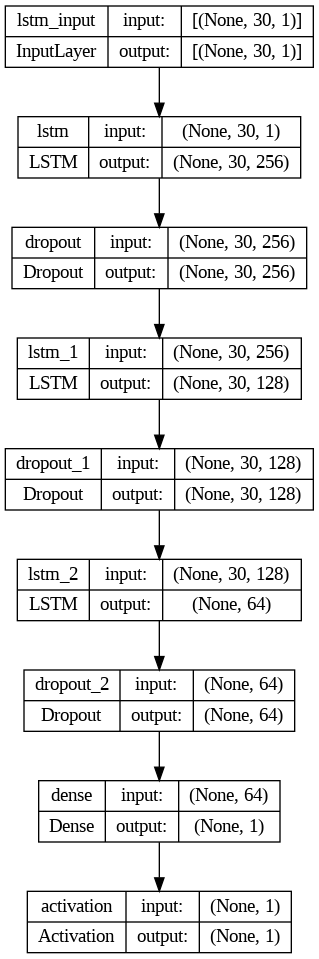

In [7]:
from tensorflow.keras.utils import plot_model
model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)
filepath = "./Checkpoints/checkpoint_model_{epoch:02d}.h5"
model_save_callback = ModelCheckpoint(
    filepath,
    monitor="val_acc",
    verbose=1,
    save_best_only=False,
    mode="auto",
    save_freq=15,
)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

TRAIN

In [9]:
model.fit(np.array(X), np.array(y), 32, 15, verbose=1, callbacks=[model_save_callback])

Epoch 1/15
  14/1218 [..............................] - ETA: 3:28 - loss: 0.1731
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
  29/1218 [..............................] - ETA: 3:29 - loss: 0.1633
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
  44/1218 [>.............................] - ETA: 3:27 - loss: 0.1625
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
  59/1218 [>.............................] - ETA: 3:49 - loss: 0.1606
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
  74/1218 [>.............................] - ETA: 3:50 - loss: 0.1594
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
  89/1218 [=>............................] - ETA: 3:43 - loss: 0.1588
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
 104/1218 [=>............................] - ETA: 3:36 - loss: 0.1584
Epoch 1: saving model to ./Checkpoints/checkpoint_model_01.h5
 119/1218 [=>............................] - ETA: 3:32 - loss: 0.

Make a prediction

In [10]:
prediction = model.predict(np.array(X_test))
prediction = np.squeeze(prediction)
prediction = np.squeeze(scaler.inverse_transform(prediction.reshape(-1, 1)))
prediction = [int(i) for i in prediction]

10/10 [==============================] - 2s 54ms/step


Save the music to a midi file

In [12]:
mid = MidiFile()
track = MidiTrack()
t = 0
for note in prediction:
    msg_on = Message.from_dict({'type': 'note_on', 'channel': 0, 'note': note, 'velocity': 67, 'time':0})
    # you need to add some pauses "note_off"
    msg_off = Message.from_dict({'type': 'note_off', 'channel': 0, 'note': note, 'velocity': 67, 'time':64})
    track.append(msg_on)
    track.append(msg_off)
    track.append(msg_off)
mid.tracks.append(track)
mid.save("generated_music.mid")
print("Generated track is saved")

Generated track is saved


In [ ]:
mid = mido.MidiFile('/content/generated_music.mid', clip=True)
mid.tracks

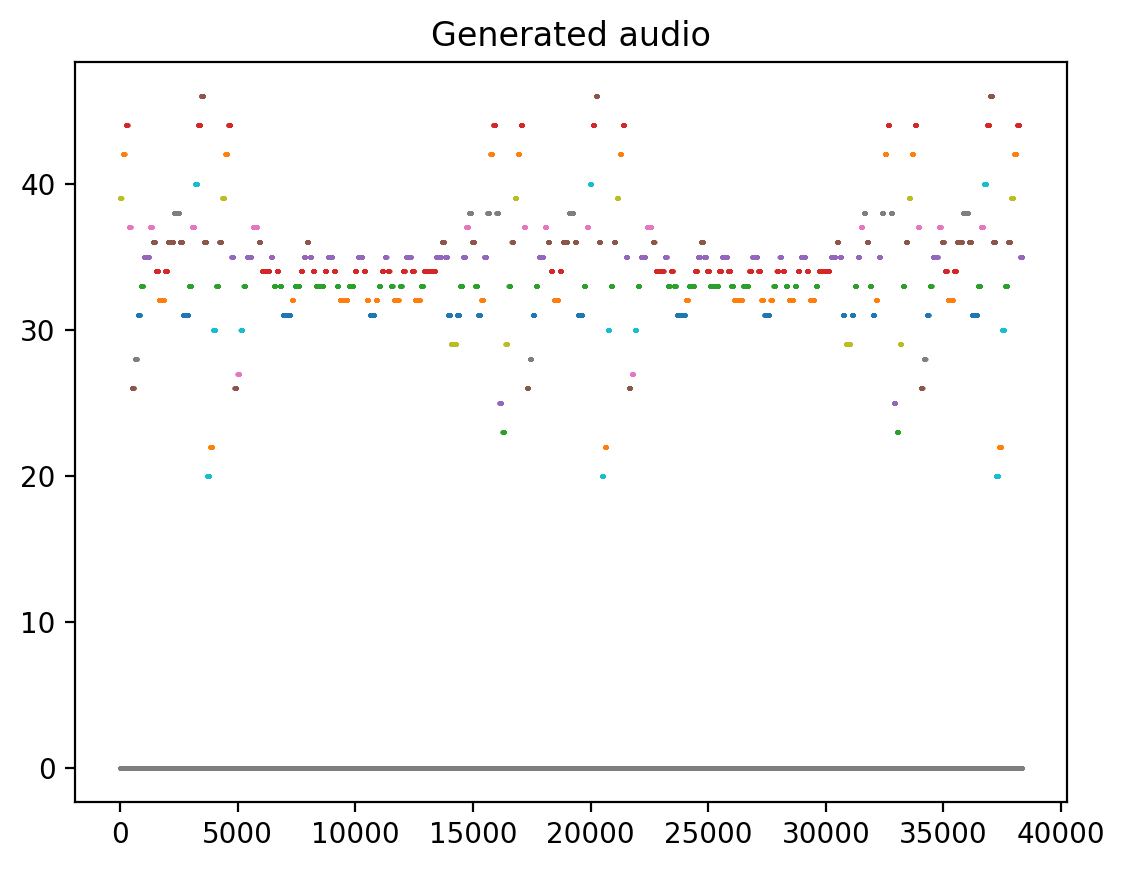

In [19]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Generated audio")
plt.savefig("generated_sample.png")
plt.show()